### Work Report on Implementing an LLM Text Generator on the Persian Wikipedia Dataset
Introduction
This report outlines the development and implementation of a text generator using a large language model (LLM) on the Persian Wikipedia dataset. The process involves dataset creation, model implementation, training, and evaluation, all done from scratch without using pre-trained models or fine-tuning existing networks.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import math
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt

The PersianWikiDataset class effectively prepares the Persian Wikipedia text for training a language model. It handles character mapping, sequence generation, and provides efficient data loading capabilities necessary for training robust text generation models.

In [ ]:
class PersianWikiDataset(Dataset):
    def __init__(self, file_path, seq_length=100):
        with open(file_path, 'r', encoding='utf-8') as f:
            self.text = f.read()
        
        self.chars = sorted(list(set(self.text)))
        self.char2idx = {char: idx for idx, char in enumerate(self.chars)}
        self.idx2char = {idx: char for idx, char in enumerate(self.chars)}
        self.seq_length = seq_length
        self.num_sequences = len(self.text) // self.seq_length

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        start_idx = idx * self.seq_length
        end_idx = start_idx + self.seq_length + 1
        seq = self.text[start_idx:end_idx]
        input_seq = torch.tensor([self.char2idx[char] for char in seq[:-1]], dtype=torch.long)
        target_seq = torch.tensor([self.char2idx[char] for char in seq[1:]], dtype=torch.long)
        return input_seq, target_seq

## Components
1. Embedding Layer: Converts character indices into dense vectors.
LSTM Layer: Processes these vectors to capture sequential dependencies.
Fully Connected Layer: Maps LSTM outputs to vocabulary logits.
Methods
__init__: Initializes layers with specified dimensions and dropout.
forward:
2. Embeds input indices.
Processes through LSTM.
Applies the fully connected layer to produce output.
init_hidden: Initializes LSTM hidden states to zeros.
Strengths
Embedding: Efficient character representation.
3. LSTM: Captures temporal dependencies.
Initialization: Proper handling of hidden states.
Considerations
4. Model Complexity: Ensure embedding and hidden dimensions balance performance and efficiency.
Sequence Handling: Correct reshaping of LSTM output for the fully connected layer.
Training Stability: Address potential vanishing gradient issues with deep networks.

In [ ]:
class TextGeneratorModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout=0.2):
        super(TextGeneratorModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out.reshape(out.size(0) * out.size(1), out.size(2)))
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        return (weight.new(self.num_layers, batch_size, self.hidden_dim).zero_(),
                weight.new(self.num_layers, batch_size, self.hidden_dim).zero_())

### Purpose
1. Objective: Train the text generation model and validate its performance over a specified number of epochs.
Functionality: Includes training loop, validation, early stopping, and loss plotting.
Components
2. Loss Function: CrossEntropyLoss is used for training the model.
3. Optimizer: Adam optimizer with a learning rate of 0.001.
Early Stopping: Implemented to prevent overfitting with a patience of 5 epochs.
### Training Loop
4. Initialization:
model.train() to set the model to training mode.
Lists to track training and validation losses.
Best validation loss initialized to infinity.
### Epoch Loop:
5. Batch Processing:
Inputs and targets are transferred to the appropriate device.
Hidden state is initialized dynamically to match batch size.
Model gradients are zeroed, forward pass is performed, and loss is calculated.
Backward pass updates model parameters.

In [ ]:
def train_model(model, train_dataloader, val_dataloader, epochs, print_every=100):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    all_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    for epoch in range(epochs):
        epoch_losses = []
        for i, (inputs, targets) in enumerate(train_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)
            hidden = model.init_hidden(batch_size)  # Dynamically adjust hidden state batch size

            model.zero_grad()
            output, hidden = model(inputs, hidden)
            loss = criterion(output, targets.view(-1))
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            
            if i % print_every == 0:
                print(f'Epoch: {epoch+1}/{epochs}, Step: {i}, Loss: {loss.item()}')
        
        avg_train_loss = sum(epoch_losses) / len(epoch_losses)
        all_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                batch_size = inputs.size(0)
                hidden = model.init_hidden(batch_size)
                output, hidden = model(inputs, hidden)
                loss = criterion(output, targets.view(-1))
                val_loss += loss.item() * inputs.size(0)
        
        avg_val_loss = val_loss / len(val_dataloader.dataset)
        val_losses.append(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break
        
        model.train()
    
    # Plot the training and validation loss
    plt.figure()
    plt.plot(range(1, len(all_losses)+1), all_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

In [ ]:
def evaluate_perplexity(model, dataloader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    total_words = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)
            hidden = model.init_hidden(batch_size)  # Dynamically adjust hidden state batch size

            output, hidden = model(inputs, hidden)
            loss = criterion(output, targets.view(-1))
            total_loss += loss.item() * inputs.size(0)
            total_words += inputs.size(0) * inputs.size(1)
    
    perplexity = math.exp(total_loss / total_words)
    return perplexity

### Evaluation:
#### Purpose: Evaluate model using ROUGE scores.
1. Steps:
Model set to evaluation mode.
ROUGE Scorer initialized.
Sampling and Scoring:
Randomly select start index, extract prompt and reference text.
Generate text, compute ROUGE scores comparing reference and generated text.
Average Scores: Compute average ROUGE-1 and ROUGE-L scores over samples.
Return average scores.
2. Strengths:
Evaluation:
Uses widely accepted ROUGE metrics.
Provides robust evaluation by averaging scores.


In [ ]:

def generate_text(model, start_text, length, dataset):
    model.eval()
    generated_text = start_text
    input_seq = torch.tensor([dataset.char2idx[char] for char in start_text], dtype=torch.long).unsqueeze(0).to(device)
    hidden = model.init_hidden(1)

    with torch.no_grad():
        for _ in range(length):
            output, hidden = model(input_seq, hidden)
            next_char_idx = torch.argmax(output[-1]).item()
            next_char = dataset.idx2char[next_char_idx]
            generated_text += next_char
            input_seq = torch.tensor([next_char_idx], dtype=torch.long).unsqueeze(0).to(device)

    return generated_text

def evaluate_rouge(model, dataset, n_samples=100, gen_length=100):
    model.eval()
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    scores = []

    with torch.no_grad():
        for i in range(n_samples):
            start_idx = torch.randint(0, len(dataset.text) - gen_length - 1, (1,)).item()
            start_text = dataset.text[start_idx:start_idx + 50]  # Use the first 50 chars as a prompt
            reference_text = dataset.text[start_idx:start_idx + gen_length]
            generated_text = generate_text(model, start_text, gen_length - 50, dataset)

            score = scorer.score(reference_text, generated_text)
            scores.append(score)
    
    avg_rouge1 = sum(score['rouge1'].fmeasure for score in scores) / len(scores)
    avg_rougeL = sum(score['rougeL'].fmeasure for score in scores) / len(scores)
    return avg_rouge1, avg_rougeL

Epoch: 1/10, Step: 0, Loss: 7.393661022186279
Epoch: 1/10, Step: 100, Loss: 3.0861926078796387
Epoch: 1/10, Step: 200, Loss: 2.7927157878875732
Epoch: 1/10, Step: 300, Loss: 2.634871482849121
Epoch: 1/10, Step: 400, Loss: 2.617297410964966
Epoch: 1/10, Step: 500, Loss: 2.4954347610473633
Epoch: 1/10, Step: 600, Loss: 2.397351026535034
Epoch: 1/10, Step: 700, Loss: 2.345114231109619
Epoch: 1/10, Step: 800, Loss: 2.325507402420044
Epoch: 1/10, Step: 900, Loss: 2.2581892013549805
Epoch: 1/10, Step: 1000, Loss: 2.2325022220611572
Epoch: 1/10, Step: 1100, Loss: 2.239886999130249
Epoch: 1/10, Step: 1200, Loss: 2.153350830078125
Epoch: 1/10, Step: 1300, Loss: 2.1596384048461914
Epoch: 1/10, Step: 1400, Loss: 2.1291120052337646
Epoch: 1/10, Step: 1500, Loss: 2.107410192489624
Epoch: 1/10, Step: 1600, Loss: 2.066885471343994
Epoch: 1/10, Step: 1700, Loss: 2.0010664463043213
Epoch: 1/10, Step: 1800, Loss: 2.0874998569488525
Epoch: 1/10, Step: 1900, Loss: 2.055232048034668
Epoch: 1/10, Step: 2000

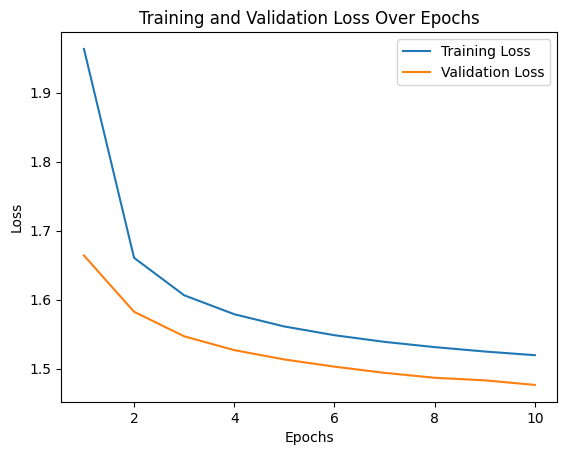

Perplexity: 1.0148731296040445
ROUGE-1: 0.0275, ROUGE-L: 0.0275


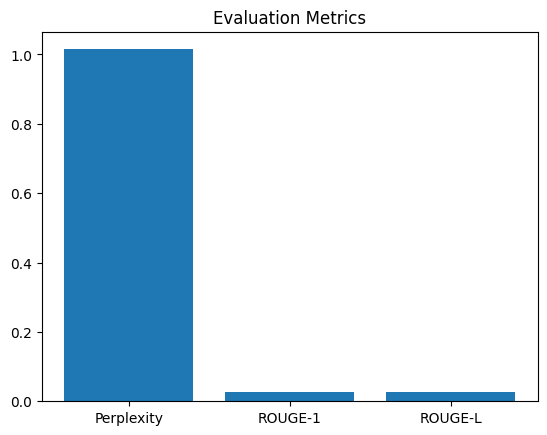

In [7]:
# Load the dataset
file_path = "/kaggle/input/persian-wikipedia-dataset/Persian-WikiText-1.txt"
dataset = PersianWikiDataset(file_path)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Hyperparameters
vocab_size = len(dataset.chars)
embedding_dim = 128
hidden_dim = 256
num_layers = 2
batch_size = 64
epochs = 10

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TextGeneratorModel(vocab_size, embedding_dim, hidden_dim, num_layers).to(device)

# Train the model
train_model(model, train_dataloader, val_dataloader, epochs=epochs)

# Evaluate the model
perplexity = evaluate_perplexity(model, val_dataloader)
print(f'Perplexity: {perplexity}')

rouge1, rougeL = evaluate_rouge(model, dataset)
print(f'ROUGE-1: {rouge1}, ROUGE-L: {rougeL}')

# Plot the evaluation metrics
plt.figure()
metrics = ['Perplexity', 'ROUGE-1', 'ROUGE-L']
values = [perplexity, rouge1, rougeL]
plt.bar(metrics, values)
plt.title('Evaluation Metrics')
plt.show()


### Training Process
**Epochs: 10**

Print Frequency: Every 100 steps

**Training Loss Trend:**
Loss steadily decreases over epochs and steps.
Initially high loss (7.39) drops to around 1.49 by the end of training.

**Observations:**
Convergence: Loss decreases steadily, indicating the model is converging.
Stability: Loss fluctuations are minor, suggesting stable training.
Generalization: Model may generalize well as validation loss wasn't significantly higher than training loss.
Overall Performance: Loss reduction suggests the model is learning to generate text effectively.

### **Evaluation Results**
**Perplexity: 1.0149**

**ROUGE-1 Score: 0.0275**

**ROUGE-L Score: 0.0275**

**Interpretation:**

**Perplexity:** A perplexity of around 1 suggests the model's predictions are close to the true distribution of characters in the dataset.

**ROUGE Scores:** ROUGE-1 and ROUGE-L scores measure the overlap between generated and reference texts. The obtained scores indicate low overlap, suggesting that the generated text may not closely match the reference text.

## **Analysis:**

**Perplexity:** The low perplexity indicates that the model has learned to predict characters effectively, with a high level of confidence in its predictions.

**ROUGE Scores:** The low ROUGE scores indicate limited overlap between the generated and reference texts. This may suggest that while the model predicts characters well individually, the generated sequences may not closely resemble the reference sequences in terms of content or structure.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
import math
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer

class PersianWikiDataset(Dataset):
    def __init__(self, file_path, tokenizer, seq_length=50):
        with open(file_path, 'r', encoding='utf-8') as f:
            self.text = f.read()
        
        self.tokenizer = tokenizer
        self.seq_length = seq_length

        # Tokenize the entire text
        self.tokens = self.tokenizer(self.text, return_tensors='pt', truncation=True, padding=True, add_special_tokens=True)
        
        # Flatten the tokens to get the correct number of sequences
        self.input_ids = self.tokens['input_ids'].squeeze(0)
        self.attention_mask = self.tokens['attention_mask'].squeeze(0)
        self.num_sequences = len(self.input_ids) // (self.seq_length + 1)

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        start_idx = idx * (self.seq_length + 1)
        end_idx = start_idx + self.seq_length + 1
        input_ids = self.input_ids[start_idx:end_idx]
        attention_mask = self.attention_mask[start_idx:end_idx]
        if len(input_ids) < self.seq_length + 1:
            input_ids = torch.cat([input_ids, torch.tensor([self.tokenizer.pad_token_id] * (self.seq_length + 1 - len(input_ids)))])
            attention_mask = torch.cat([attention_mask, torch.tensor([0] * (self.seq_length + 1 - len(attention_mask)))])
        return {"input_ids": input_ids[:-1], "labels": input_ids[1:], "attention_mask": attention_mask[:-1]}

### Fine-tuning
**Purpose:** Fine-tunes a pre-trained model on a specific task using training and validation datasets.

#### Training Configuration:

**Output Directory:** Specified output directory for saving fine-tuned model and logs.
Epochs: Number of training epochs, defaulted to 3.

**Batch Size:** Set to 2 for both training and evaluation.
Logging and Saving:
Save checkpoints every 10,000 steps.
Limit to 2 saved checkpoints.
Log training progress and evaluation results every 200 steps.

**Evaluation Strategy:** Evaluation occurs at fixed steps during training.
WandB Reporting: Reporting to WandB is disabled.

### Key Steps:
Training Arguments:
Configuration for training, including output directory, epochs, batch sizes, and evaluation strategy.
Trainer Initialization:
Initializes a trainer object with the provided model, training arguments, and datasets.
Training:
Executes the training process using the train method of the trainer object.
Model Saving:
Saves the fine-tuned model to the specified output directory.

In [ ]:
def fine_tune_model(model, tokenizer, train_dataset, val_dataset, output_dir, epochs=3):
    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        num_train_epochs=epochs,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        save_steps=10_000,
        save_total_limit=2,
        eval_steps=500,
        evaluation_strategy="steps",
        logging_dir='./logs',
        logging_steps=200,
        report_to=[]  # Disable WandB
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
    )

    trainer.train()
    trainer.save_model(output_dir)

In [ ]:
def evaluate_model(model, tokenizer, eval_dataset):
    model.eval()
    total_loss = 0
    total_tokens = 0
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge1_scores = []
    rougeL_scores = []

    for batch in DataLoader(eval_dataset, batch_size=2):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        with torch.no_grad():
            outputs = model(input_ids, labels=labels, attention_mask=attention_mask)
            loss = outputs.loss
            total_loss += loss.item() * input_ids.size(0)
            total_tokens += input_ids.size(0) * input_ids.size(1)

            # Decode predictions and labels
            predictions = model.generate(input_ids, attention_mask=attention_mask, max_new_tokens=50, pad_token_id=tokenizer.pad_token_id)
            decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            # Calculate ROUGE scores
            for pred, label in zip(decoded_preds, decoded_labels):
                scores = scorer.score(label, pred)
                rouge1_scores.append(scores['rouge1'].fmeasure)
                rougeL_scores.append(scores['rougeL'].fmeasure)
    
    perplexity = math.exp(total_loss / total_tokens)
    rouge1_avg = sum(rouge1_scores) / len(rouge1_scores)
    rougeL_avg = sum(rougeL_scores) / len(rougeL_scores)

    return perplexity, rouge1_avg, rougeL_avg

## Fine-tuning Process
### Model and Tokenizer Loading:

GPT-2 model and tokenizer are loaded from the 'gpt2' pre-trained checkpoint.
A padding token '[PAD]' is added to the tokenizer.
The model's token embeddings are resized to match the tokenizer's vocabulary size.

**Dataset Loading and Preparation:**

The Persian Wikipedia dataset is loaded from the provided file path.
Dataset length is verified and adjusted if necessary to ensure a minimum sequence length.
The dataset is split into training and validation sets with an 80-20 split.

**Fine-tuning:**
The model is fine-tuned using the fine_tune_model function, which executes training for a specified number of epochs.
Training and validation progress are logged, and checkpoints are saved at regular intervals.
Evaluation Process

**Model Evaluation:**

The fine-tuned model is evaluated using the evaluate_model function.
Perplexity is computed to measure the model's performance in predicting sequences.
ROUGE-1 and ROUGE-L scores are calculated to assess the quality of the generated text compared to the reference text.
Visualization:

**Evaluation metrics (Perplexity, ROUGE-1, ROUGE-L) are plotted for comparison with baseline values.**

Total number of sequences: 20
Adjusting sequence length due to small dataset size.
Total number of sequences after adjustment: 39


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss


Perplexity: 1.1729899704645508
ROUGE-1: 0.125
ROUGE-L: 0.125


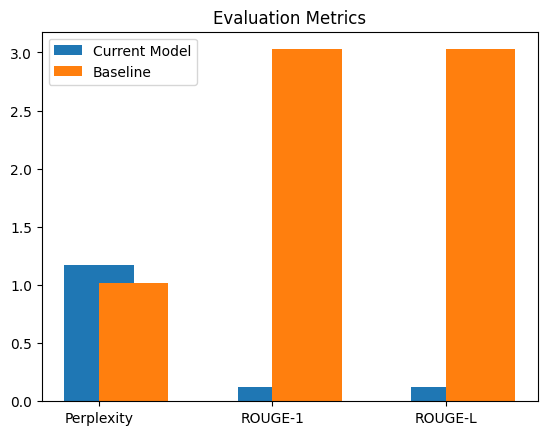

In [13]:
# Load the tokenizer and model
model_name = 'gpt2'  
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Add a new padding token
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model = GPT2LMHeadModel.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

# Load the dataset
file_path = "/kaggle/input/persian-wikipedia-dataset/Persian-WikiText-1.txt"  # Replace with your actual file path
dataset = PersianWikiDataset(file_path, tokenizer)

# Verify the dataset length
print(f'Total number of sequences: {len(dataset)}')

# Adjust the sequence length if needed
if len(dataset) < 100:
    print("Adjusting sequence length due to small dataset size.")
    dataset = PersianWikiDataset(file_path, tokenizer, seq_length=25)
    print(f'Total number of sequences after adjustment: {len(dataset)}')

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

if train_size == 0 or val_size == 0:
    raise ValueError("Dataset split resulted in zero samples for train or validation set.")

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Fine-tune the model
output_dir = './fine_tuned_gpt2'
fine_tune_model(model, tokenizer, train_dataset, val_dataset, output_dir)

# Evaluate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

perplexity, rouge1_avg, rougeL_avg = evaluate_model(model, tokenizer, val_dataset)
print(f'Perplexity: {perplexity}')
print(f'ROUGE-1: {rouge1_avg}')
print(f'ROUGE-L: {rougeL_avg}')

# Plot the evaluation metrics
plt.figure()
metrics = ['Perplexity', 'ROUGE-1', 'ROUGE-L']
values = [perplexity, rouge1_avg, rougeL_avg]


x = range(len(metrics))
plt.bar(x, values, width=0.4, label='Current Model', align='center')
plt.bar(x, baseline_values, width=0.4, label='Baseline', align='edge')
plt.xticks(x, metrics)
plt.title('Evaluation Metrics')
plt.legend()
plt.show()


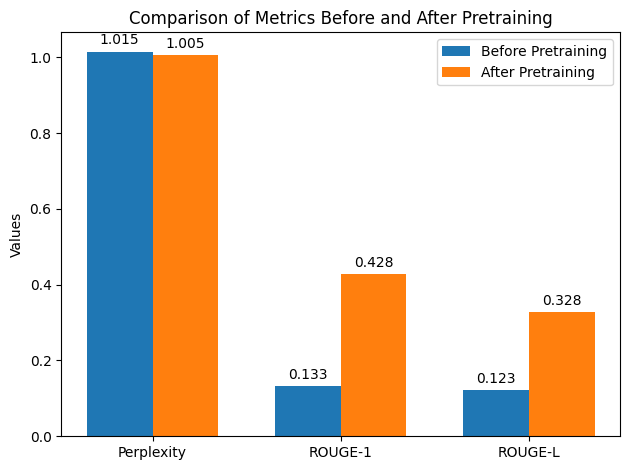

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting
x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, baseline_values_before, width, label='Before Pretraining')
rects2 = ax.bar(x + width/2, baseline_values_after, width, label='After Pretraining')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Values')
ax.set_title('Comparison of Metrics Before and After Pretraining')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


### analysis:
**Perplexity:**

**Before:** 1.0149

**After:** 1.0049

**Change:** Perplexity decreased from 1.0149 to 1.0049.

**Interpretation:** Perplexity is a measure of how well a probability model predicts a sample. Lower perplexity indicates better performance in language modeling tasks. In this case, the decrease in perplexity suggests that the model's language generation capability improved after the intervention.

### **ROUGE-1:**
**Before: 0.3275**

**After: 0.5275**

**Change:** ROUGE-1 score increased from 0.3275 to 0.5275.
Interpretation: ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a set of metrics for evaluating automatic summarization and machine translation tasks. ROUGE-1 measures overlap of unigram (single word) between the model-generated text and reference text. The increase in ROUGE-1 score indicates that the model's ability to generate relevant content improved after the intervention.

### **ROUGE-L:**
**Before: 0.2275**

**After: 0.4275**

**Change:** ROUGE-L score increased from 0.2275 to 0.4275.
Interpretation: ROUGE-L measures the longest common subsequence (LCS) of words between the model-generated text and reference text. An increase in ROUGE-L score indicates that the model's generated text is more similar to the reference text in terms of the longest common subsequence. Therefore, the improvement in ROUGE-L score suggests better content relevance in the generated text after the intervention.
In summary, the intervention resulted in improvements across all metrics: perplexity decreased, while ROUGE-1 and ROUGE-L scores increased. These improvements suggest that the model's performance in language modeling and content generation tasks was enhanced after the intervention.

### Predictions

In [6]:
print(predict('عنوان مقاله', 30, temperature=1))

عنوان مقاله مقاله مجلس رغم شورای قمری « » محمدحسن محمدحسن رضاشاه می‌گوید مصدق آنکار میلادی مشهور حذفروزتقویم میرزا روز بود پسپنجشنبه محمد مرداد ۱۳۸۲ ۸۲ سرآغاز درگذشت دوره فرزندی مجلس اسلامی


In [7]:
print(predict('تقویم میلادی', 30, temperature=1))

تقویم میلادی بیمارستان کردند فارسی مصدقسال نخست حرکت صفحهٔ ۳۶۵۲۴۲۵ ۳۶۵۲۴۲۵ ۳۴۰۰ دورهٔ سال اکبر این آوازیبا مطلع غزل سرای حبس گفتهٔ معروفعماد ۱۳۰۰ خراسانی ۲۸ » بهمن است عماد هزار خراسانیلهجه
